# $\sim$ No-Two-Holes-Touching (NTHT) Mask
In the following code, we generate "from scratch" a new mask for LEM-X with the following characteristics:
-  Open-fraction in the range $\leq 0.50$ (so we start from 0.50 of original open fraction)
-  1040 elements along the fine (X) direction
-  17 elements along the coarse (Y) direction
-  0.25 mm pitch in the fine (X) direction
-  15.5 mm pitch in the coarse (Y) direction
-  2.5 mm ribs
-  Maximum homogeneity along row and columns


In [1]:
%matplotlib ipympl
import numpy as np
import sys

# setting path for mask_utils package
sys.path.append('..')

from mask_utils.code_utils import next_prime, ura_mura
from mask_utils.imaging_utils import solid_angle, decode, decode_var, generate_bulk, get_openfraction, eff_area_vs_off_axis, get_skysign, get_skycoords
from mask_utils.fits_utils import read_mask_bulk, write_mask_fits
from mask_utils.image_utils import upscale, fshift

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
yele = 17
xele = 1040
nele = xele * yele

In [3]:
focal = 202.9
mpitch_x = 0.25
mpitch_y = 15.5
ribsize_y = 2.5
ELXDIM = 0.25
ELYDIM = 0.5

## MASK CODE

To generate the code we use eq. 10 From Gottesman and Fenimore, AO, Vol. 28, No. 20 / 15 October 1989

https://opg.optica.org/ao/fulltext.cfm?uri=ao-28-20-4344&id=32882

Using quadratic residues for primes $v = 4x + 1$ or $v = 4x + 3$ with $x$ odd

In [4]:
# Generating the code using the nearest prime which satisfies the ura conditions
prime_gen = next_prime(nele)
full_code=ura_mura(prime_gen)
print("Generating prime:", prime_gen)

Generating MURA array
Generating prime: 17681


## MASK SPATIAL HOMOGENEITY
Using a brute force approach, we try to determine the cyclic code shift which
maximize the mask symmetry.
To do that, for each shift we calculate the variance matrix and estimate its symmetry

Please note that this is a long process...

In [5]:
"""
res = np.zeros(prime_gen)

for ss in range(0, prime_gen):
    shifted = np.roll(full_code, ss)
    mask = shifted[0:nele].reshape(xele, yele, order='C')
    of =  np.sum(mask)/mask.size
    rmatrix = np.ones(mask.shape)
    rmatrix[mask <1] = -1 * (1.0 - 1.0/(nele * of)) * of/(1.0-of)
    
    variance = decode_var(mask, rmatrix, np.ones(mask.shape), focal, mpitch_x, mpitch_y)
    residual = abs(variance - np.flip(variance, axis=None))
    
    res[ss] = np.sum(residual)

opt_shift  = np.argmin(res)
"""

"\nres = np.zeros(prime_gen)\n\nfor ss in range(0, prime_gen):\n    shifted = np.roll(full_code, ss)\n    mask = shifted[0:nele].reshape(xele, yele, order='C')\n    of =  np.sum(mask)/mask.size\n    rmatrix = np.ones(mask.shape)\n    rmatrix[mask <1] = -1 * (1.0 - 1.0/(nele * of)) * of/(1.0-of)\n\n    variance = decode_var(mask, rmatrix, np.ones(mask.shape), focal, mpitch_x, mpitch_y)\n    residual = abs(variance - np.flip(variance, axis=None))\n\n    res[ss] = np.sum(residual)\n\nopt_shift  = np.argmin(res)\n"

Optimal code shift: 17680
Original OF: 0.5


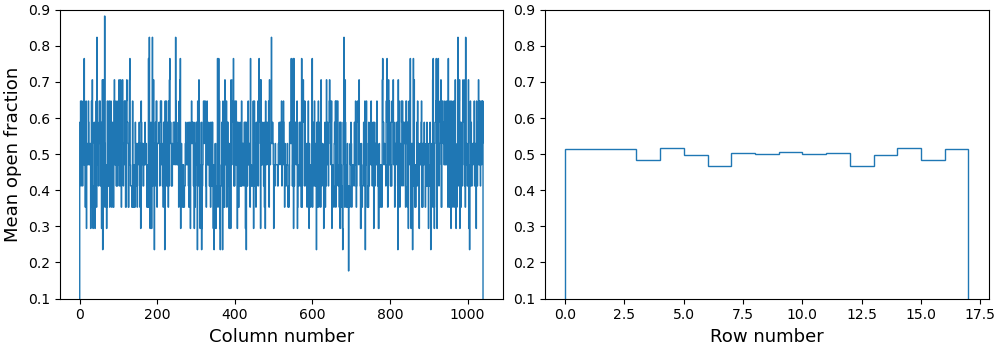

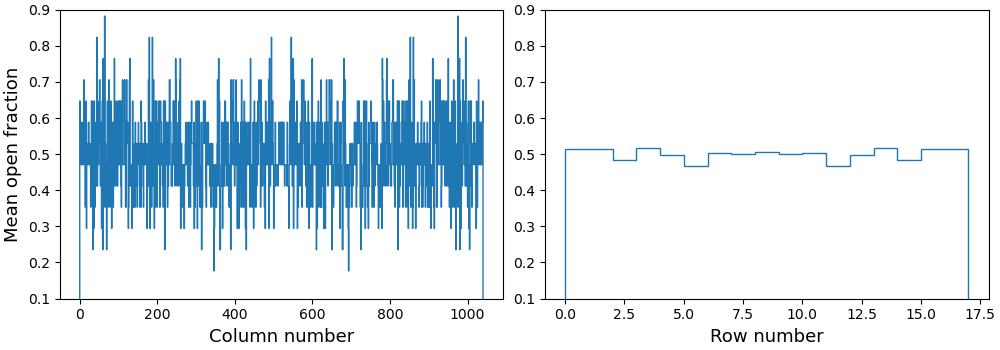

In [6]:
opt_shift = 17680 #For MURA the optimal code shift is p-1...
print("Optimal code shift:", opt_shift)


shifted = np.roll(full_code, opt_shift)
mask_base = shifted[0:nele].reshape(xele, yele, order='C')

preshift_mask_base = full_code[0:nele].reshape(xele, yele, order='C')

xcollapse = mask_base.sum(axis=1)/yele
ycollapse = mask_base.sum(axis=0)/xele

preshift_xcollapse = preshift_mask_base.sum(axis=1)/yele
preshift_ycollapse = preshift_mask_base.sum(axis=0)/xele

original_of =  np.sum(mask_base)/mask_base.size
print("Original OF:", original_of)


# Plotting collapsed projections before and after shifting

#Before shifting
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
#axs[0].set_title('Fine Direction')
axs[0].stairs(preshift_xcollapse)
axs[0].set_ylabel("Mean open fraction", fontsize=13)
axs[0].set_xlabel("Column number", fontsize=13)
#axs[1].set_title('Coarse Direction')
axs[1].stairs(preshift_ycollapse)
axs[1].set_xlabel("Row number", fontsize=13)

axs[0].set_ylim(0.1, 0.9)
axs[1].set_ylim(0.1, 0.9)
plt.savefig("mask_homogeneity_preshift.pdf", format="pdf", bbox_inches="tight")

plt.show()

#After shifting
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
#axs[0].set_title('Fine Direction')
axs[0].stairs(xcollapse)
axs[0].set_ylabel("Mean open fraction", fontsize=13)
axs[0].set_xlabel("Column number", fontsize=13)
#axs[1].set_title('Coarse Direction')
axs[1].stairs(ycollapse)
axs[1].set_xlabel("Row number", fontsize=13)

axs[0].set_ylim(0.1, 0.9)
axs[1].set_ylim(0.1, 0.9)
plt.savefig("mask_homogeneity_postshift.pdf", format="pdf", bbox_inches="tight")

plt.show()


## MASK WITHOUT RIBS
We try to find the best geometric solution for this mask, considering that we don't need ribs before the first row and after the last. This design give us a 261.0 mm mask (in Y) and of course a 260 mm mask in X. The total number of ribs is 16

In [7]:
print(mask_base.shape)

(1040, 17)


In [8]:
# Now we upscale the mask
upf_x = mpitch_x / ELXDIM #=1, no upscaling needed
upf_y = mpitch_y / ELYDIM

mask_original = upscale(mask_base, upf_y, upf_x)

#And the RMATRIX, remembering that MURA element 0 (before shifting!) must be forced to 1
"""
rmatrix = full_code
rmatrix[full_code < 1] = -1 * (1.0 - 1.0/(nele * original_of)) * original_of/(1.0-original_of)
rmatrix[0] = 1

rmatrix = np.roll(rmatrix, opt_shift)
rmatrix = rmatrix[0:nele].reshape(xele, yele, order='C')
rmatrix = upscale(rmatrix, upf_y, upf_x)
rmatrix.shape
"""

#RMATRIX element corresponding to code element 0 should be forced to 1
#but with the shift used (17680) such element is out of our mask/rmatrix
rmatrix = np.ones(mask_original.shape)
rmatrix[mask_original < 1] = -1 * (1.0 - 1.0/(nele * original_of)) * original_of/(1.0-original_of)

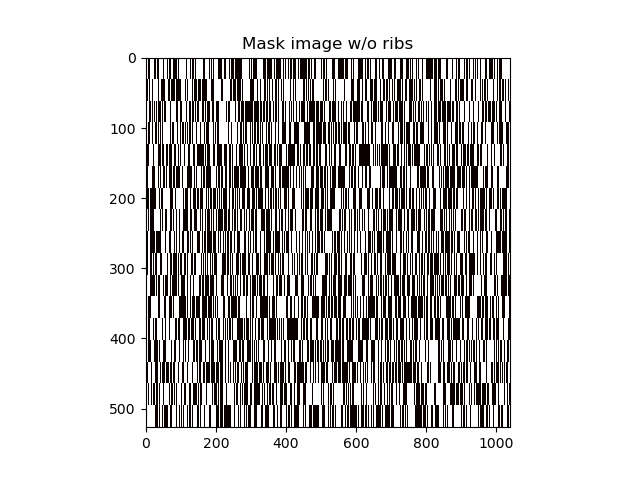

In [9]:
plt.figure()
plt.title('Mask image w/o ribs')
plt.imshow(mask_original.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

## RIBS
Now we force to zero the ribs (along the mask rows).

In [10]:
mask = np.zeros(mask_original.shape)
mask[mask_original == 1] = 1

# Select ribs index from the upscaled mask
selected_rows = []
for start in range(0, mask_original.shape[1],  int(mpitch_y / ELYDIM)):
    selected_rows.extend(range(start, min(start + int(ribsize_y/ELYDIM)-1, mask.shape[1])))

# Force the selected rows to 0
mask[:, selected_rows] = 0
rmatrix[:, selected_rows] = 0

#Remove the first ribsize_y/ELYDIM rows
mask = mask[:, int(ribsize_y/ELYDIM)-1:-1]
rmatrix = rmatrix[:, int(ribsize_y/ELYDIM)-1:-1]


print("Total mask dimension [elements]:", mask.shape)
print("Total mask dimension [mm]:", mask.shape[0] * ELXDIM, "x",  mask.shape[1] * ELYDIM)
print("Ribs dimension [elements]", ribsize_y/ELYDIM)
print("Ribs step [elements]", mpitch_y / ELYDIM)

Total mask dimension [elements]: (1040, 522)
Total mask dimension [mm]: 260.0 x 261.0
Ribs dimension [elements] 5.0
Ribs step [elements] 31.0


C:\Users\Utente\AppData\Local\Temp\ipykernel_9736\2853108822.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gray_r = cm.get_cmap('gray_r', 256)
C:\Users\Utente\AppData\Local\Temp\ipykernel_9736\2853108822.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gray_r = cm.get_cmap('Blues_r', 256)


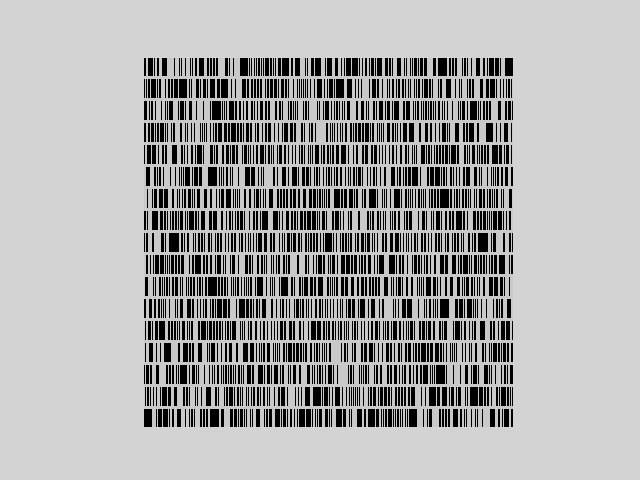

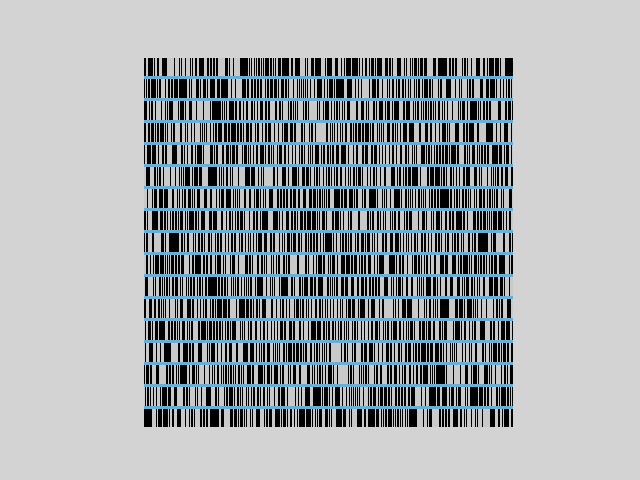

In [11]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
gray_r = cm.get_cmap('gray_r', 256)
gray_r = cm.get_cmap('Blues_r', 256)

mycm = gray_r(np.linspace(0, 1, 256))
mycm[:64, :] = ((0,0,0,0.05))
mycm[-64:, :] = ((0,0,0,1))


newcmp = ListedColormap(mycm)

plt.figure(facecolor="lightgray")
#plt.title('Mask image w ribs')
plt.imshow(mask.T, cmap=newcmp,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.axis('off')
plt.rcParams['savefig.facecolor']='lightgray'
plt.savefig("LEM-X_1040x17_coded_mask.pdf", format="pdf", bbox_inches="tight")
plt.show()


plt.figure(facecolor="lightgray")
plt.axis('off')
#plt.title('R-matrix w ribs')
plt.imshow(rmatrix.T, cmap=newcmp,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.rcParams['savefig.facecolor']='lightgray'
plt.savefig("LEM-X_1040x17_coded_mask_highlighted_ribs.pdf", format="pdf", bbox_inches="tight", pad_inches=0.3, dpi=300)

plt.show()


## Open Fraction

In [12]:
openfraction = get_openfraction(mask)
print("Final open fraction", openfraction) 

Final open fraction 0.4386678455643973


## TEST SKY IMAGE

In [13]:
mask.shape

(1040, 522)

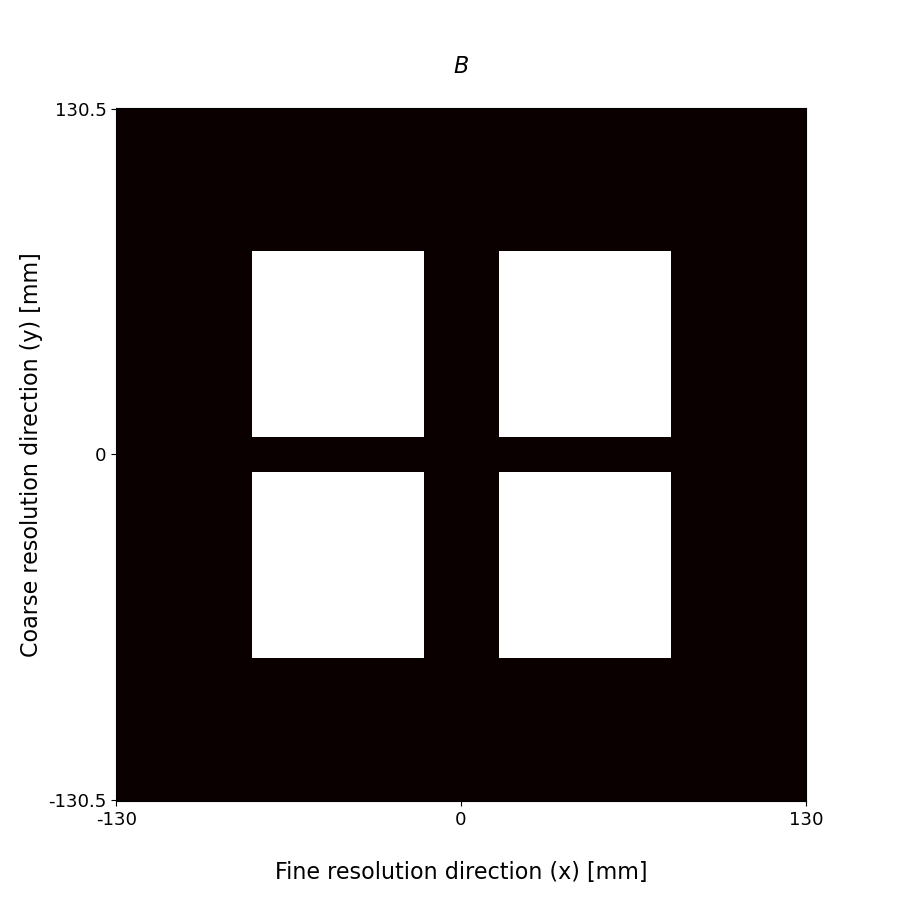

In [14]:
#Defining bulk array
bulk = generate_bulk(mask.shape, ELXDIM, ELYDIM)

plt.figure(figsize=(9, 9))
plt.title('$B$\n', fontsize=16)
plt.xticks([0, 519, 1039], labels=[-130,0, 130], fontsize=13)
plt.yticks([0, 260, 521], labels=[130.5,0, -130.5], fontsize=13)
plt.xlabel("\nFine resolution direction (x) [mm]", fontsize=16)
plt.ylabel("\nCoarse resolution direction (y) [mm]", fontsize=16)


#ax.set_yticks(range(len(camera_reqs)), ha="right", labels=camera_reqs, fontsize=13)
plt.imshow(bulk.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.rcParams['savefig.facecolor']='white'
plt.savefig("LEM-X_bulk_array.pdf", format="pdf", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\T'
<>:31: SyntaxWarning: invalid escape sequence '\T'
<>:23: SyntaxWarning: invalid escape sequence '\T'
<>:31: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Utente\AppData\Local\Temp\ipykernel_9736\217931942.py:23: SyntaxWarning: invalid escape sequence '\T'
  axs[0].set_xlabel("Fine direction off-axis angle  ($\Theta_{\mathrm{fine}}$) [deg]\n", fontsize=16)
C:\Users\Utente\AppData\Local\Temp\ipykernel_9736\217931942.py:31: SyntaxWarning: invalid escape sequence '\T'
  axs[1].set_xlabel("Coarse direction off-axis angle  ($\Theta_{\mathrm{coarse}}$) [deg]\n", fontsize=16)


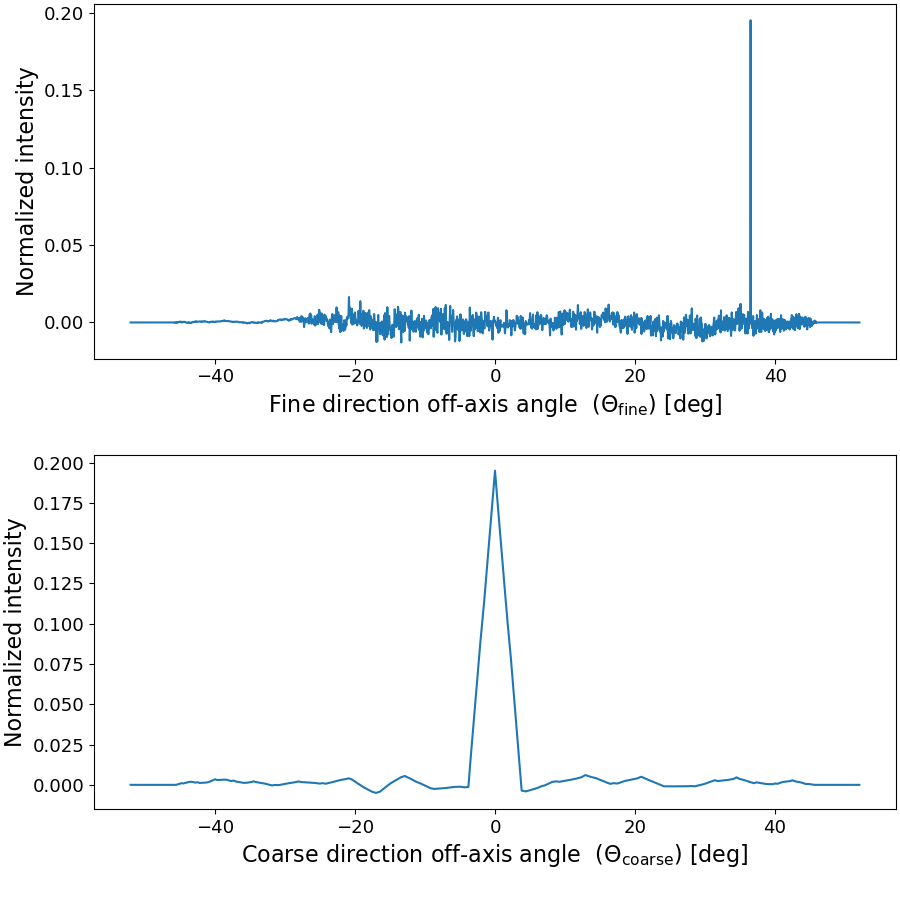

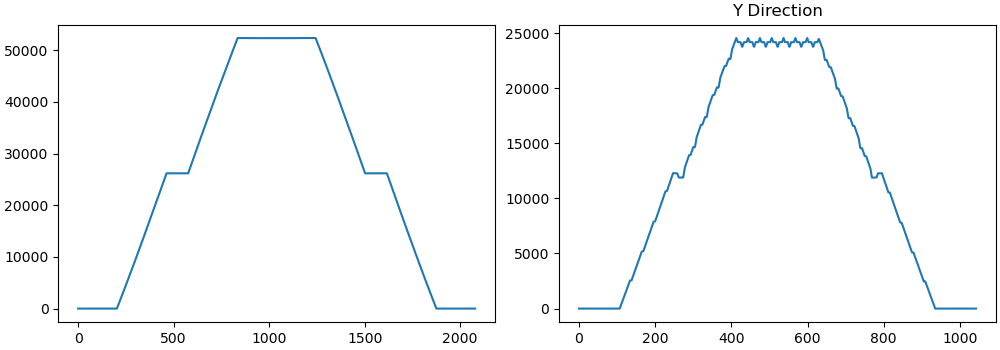

(2079, 1043)

In [49]:
sky = decode(fshift(mask, -600, 0)*bulk, rmatrix, bulk)
peak = np.max(sky)
peak_p = np.unravel_index(np.argmax(sky), sky.shape)

s = np.shape(sky)

x = (np.linspace(0, s[0]*ELXDIM, num=s[0]) )
y = (np.linspace(0, s[1]*ELYDIM, num=s[1]) )
x -= x[-1]/2
y -= y[-1]/2

skycoordX = np.rad2deg(np.arctan(x/focal))
skycoordY = np.rad2deg(np.arctan(y/focal))

variance = decode_var(mask*bulk, rmatrix, bulk, focal, ELXDIM, ELYDIM)

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(9, 9))
axs[0].set_title('')
axs[0].plot(skycoordX, sky[:, peak_p[1]]/np.sum(bulk))
#axs[0].set_xticks([0, 620, 1040, 1660, 2080], labels=[-2080, 1040, 0, 1040, 2080], fontsize=13)
#axs[0].set_yticks([0,0.5, 1], labels=[0,0.5,1], fontsize=13)

axs[0].set_xlabel("Fine direction off-axis angle  ($\Theta_{\mathrm{fine}}$) [deg]\n", fontsize=16)
axs[0].set_ylabel("Normalized intensity", fontsize=16)

axs[1].set_title('')
axs[1].plot(skycoordY, sky[peak_p[0], :]/np.sum(bulk))
#axs[1].set_xticks([0, 261, 522, 261+ 522, 1044], labels=[-522, -261, 0, 261, 522], fontsize=13)
#axs[1].set_yticks([0,0.5, 1], labels=[0,0.5,1], fontsize=13)

axs[1].set_xlabel("Coarse direction off-axis angle  ($\Theta_{\mathrm{coarse}}$) [deg]\n", fontsize=16)
axs[1].set_ylabel("Normalized intensity", fontsize=16)

axs[0].xaxis.set_tick_params(labelsize=13)
axs[0].yaxis.set_tick_params(labelsize=13)

axs[1].xaxis.set_tick_params(labelsize=13)
axs[1].yaxis.set_tick_params(labelsize=13)


#plt.savefig("LEM-X_mask_autocorr_slices.pdf", format="pdf", bbox_inches="tight", pad_inches=0.0, dpi=300)

plt.show()

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
axs[0].set_title('')
axs[0].plot(variance[:, peak_p[1]])
axs[1].set_title('Y Direction')
axs[1].plot(variance[peak_p[0], :])
plt.show()

variance.shape

In [46]:
sky.shape

(2079, 1043)

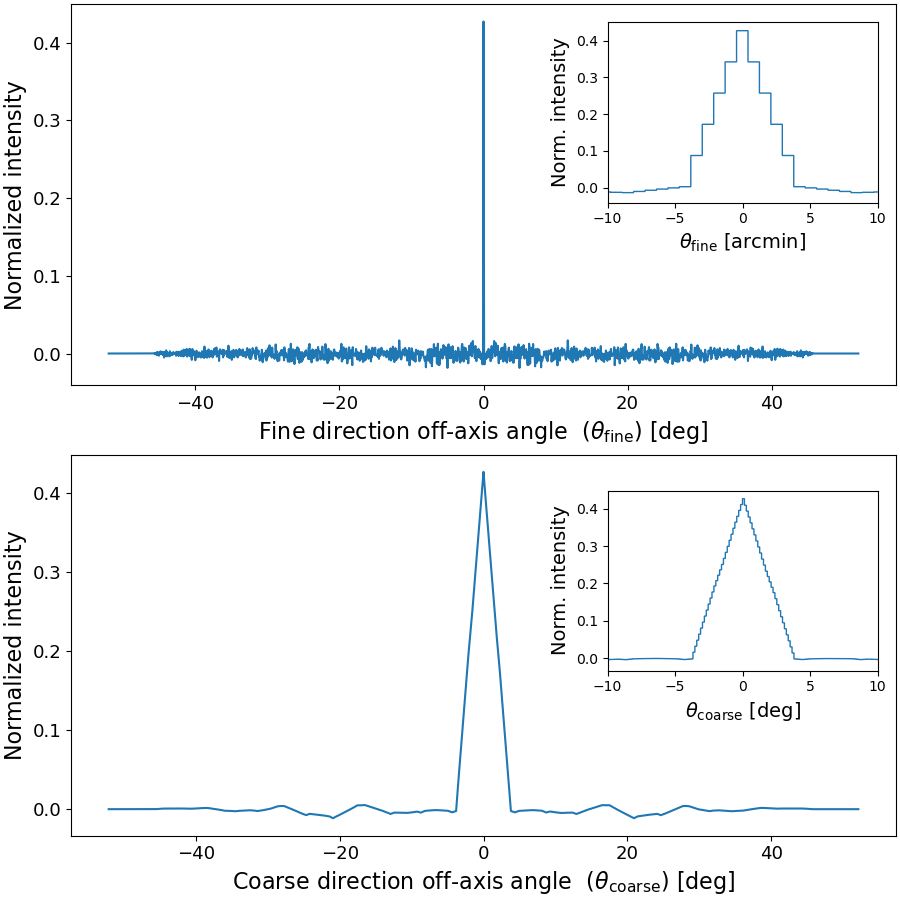

In [47]:
#Upscaling mask, rmatrix, bulk
up_f_x, up_f_y = 5, 1

mask_us = upscale(mask, up_f_y, up_f_x)
rmatrix_us= upscale(rmatrix, up_f_y, up_f_x)
bulk_us = upscale(bulk, up_f_y, up_f_x)

ELXDIM_US = ELXDIM / up_f_x
ELYDIM_US = ELYDIM / up_f_y

sky_us = decode(mask_us*bulk_us, rmatrix_us, bulk_us)
peak_us = np.max(sky_us)
peak_p_us = np.unravel_index(np.argmax(sky_us), sky_us.shape)

s = np.shape(sky_us)

x = (np.linspace(0, s[0]*ELXDIM_US, num=s[0]) )
y = (np.linspace(0, s[1]*ELYDIM_US, num=s[1]) )
x -= x[-1]/2
y -= y[-1]/2

skycoordX_us = np.rad2deg(np.arctan(x/focal))
skycoordY_us = np.rad2deg(np.arctan(y/focal))



fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(9, 9))
left, bottom, width, height = [0.675, 0.775, 0.3, 0.2]
axs0_inset = fig.add_axes([left, bottom, width, height])
axs1_inset = fig.add_axes([left, 0.255, width, height])


axs[0].set_title('')
axs[0].plot(skycoordX_us, sky_us[:, peak_p_us[1]]/np.sum(bulk_us))
axs[0].set_xlabel(r"Fine direction off-axis angle  ($\theta_{\mathrm{fine}}$) [deg]", fontsize=16)
axs[0].set_ylabel("Normalized intensity", fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=13)
axs[0].yaxis.set_tick_params(labelsize=13)

edges = np.append(skycoordX_us, skycoordX_us[-1])
axs0_inset.stairs(sky_us[:, peak_p_us[1]]/np.sum(bulk_us), edges*60-0.44)
axs0_inset.set_xlim((-10,10))
axs0_inset.set_xlabel(r"$\theta_{\mathrm{fine}}$ [arcmin]", fontsize=14)
axs0_inset.set_ylabel("Norm. intensity", fontsize=14)

axs[1].set_title('')
axs[1].plot(skycoordY_us, sky_us[peak_p_us[0], :]/np.sum(bulk_us))
axs[1].set_xlabel(r"Coarse direction off-axis angle  ($\theta_{\mathrm{coarse}}$) [deg]", fontsize=16)
axs[1].set_ylabel("Normalized intensity", fontsize=16)
axs[1].xaxis.set_tick_params(labelsize=13)
axs[1].yaxis.set_tick_params(labelsize=13)


edges = np.append(skycoordY_us, skycoordY_us[-1])
axs1_inset.stairs(sky_us[peak_p_us[0], :]/np.sum(bulk_us), edges)
axs1_inset.set_xlim((-10,10))
axs1_inset.set_xlabel(r"$\theta_{\mathrm{coarse}}$ [deg]", fontsize=14)
axs1_inset.set_ylabel("Norm. intensity", fontsize=14)

#plt.savefig("LEM-X_mask_autocorr_slices_inset.pdf", format="pdf", bbox_inches="tight", pad_inches=0.0, dpi=300)

plt.show()


<>:22: SyntaxWarning: invalid escape sequence '\T'
<>:30: SyntaxWarning: invalid escape sequence '\T'
<>:22: SyntaxWarning: invalid escape sequence '\T'
<>:30: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Utente\AppData\Local\Temp\ipykernel_9736\1024880393.py:22: SyntaxWarning: invalid escape sequence '\T'
  axs[0].set_xlabel("$\Theta_{\mathrm{fine}}$ [arcmin]\n", fontsize=16)
C:\Users\Utente\AppData\Local\Temp\ipykernel_9736\1024880393.py:30: SyntaxWarning: invalid escape sequence '\T'
  axs[1].set_xlabel("$\Theta_{\mathrm{coarse}}$ [deg]\n", fontsize=16)


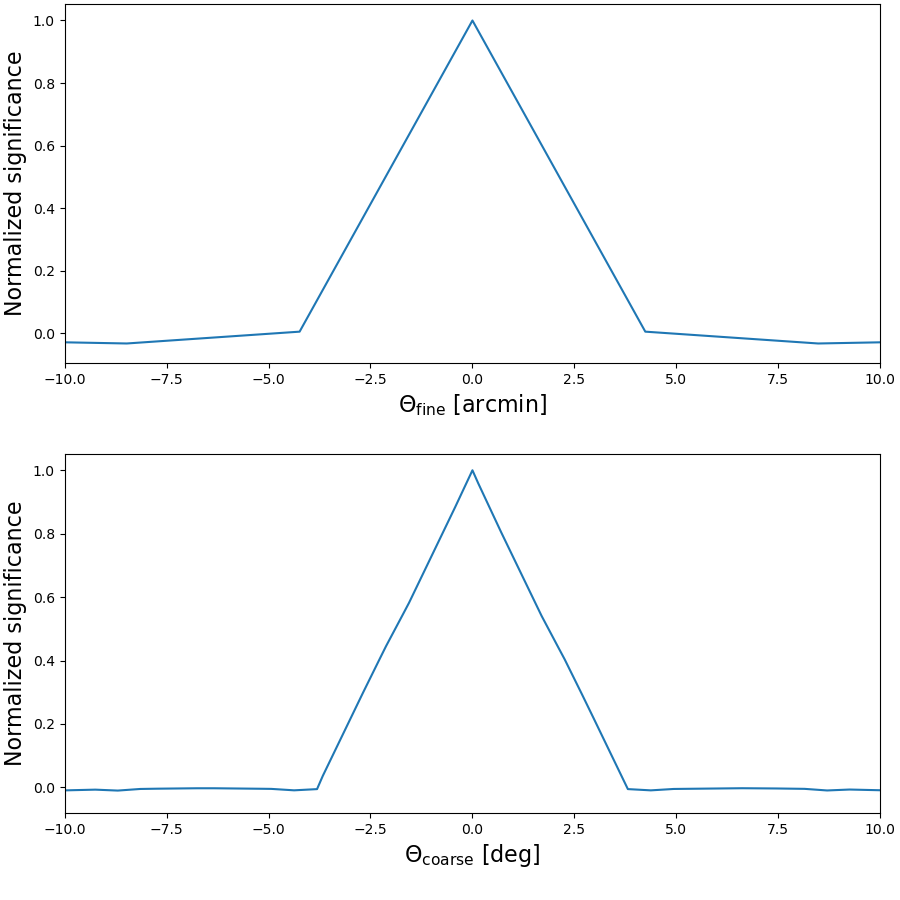

In [17]:
variance = decode_var(mask*bulk, rmatrix, bulk, focal, ELXDIM, ELYDIM)

sign = get_skysign(sky, variance)

s = np.shape(sign)

x = (np.linspace(0, s[0]*ELXDIM, num=s[0]) )
y = (np.linspace(0, s[1]*ELYDIM, num=s[1]) )
x -= x[-1]/2
y -= y[-1]/2

skycoordX = np.rad2deg(np.arctan(x/focal))
skycoordY = np.rad2deg(np.arctan(y/focal))

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(9, 9))
axs[0].set_title('')
axs[0].plot(skycoordX*60, sign[:, peak_p[1]]/np.max(sign[np.isfinite(sign)]))
#axs[0].set_xticks([0, 620, 1040, 1660, 2080], labels=[-2080, 1040, 0, 1040, 2080], fontsize=13)
axs[0].set_xlim((-10,10))
#axs[0].set_yticks([0,0.5, 1], labels=[0,0.5,1], fontsize=13)

axs[0].set_xlabel("$\Theta_{\mathrm{fine}}$ [arcmin]\n", fontsize=16)
axs[0].set_ylabel("Normalized significance", fontsize=16)

axs[1].set_title('')
axs[1].plot(skycoordY, sign[peak_p[0], :]/np.max(sign[np.isfinite(sign)]))
#axs[1].set_xticks([0, 261, 522, 261+ 522, 1044], labels=[-522, -261, 0, 261, 522], fontsize=13)
#axs[1].set_yticks([0,0.5, 1], labels=[0,0.5,1], fontsize=13)
axs[1].set_xlim((-10,10))
axs[1].set_xlabel("$\Theta_{\mathrm{coarse}}$ [deg]\n", fontsize=16)
axs[1].set_ylabel("Normalized significance", fontsize=16)
#plt.savefig("LEM-X_mask_autocorr_slices.pdf", format="pdf", bbox_inches="tight", pad_inches=0.0, dpi=300)

plt.show()

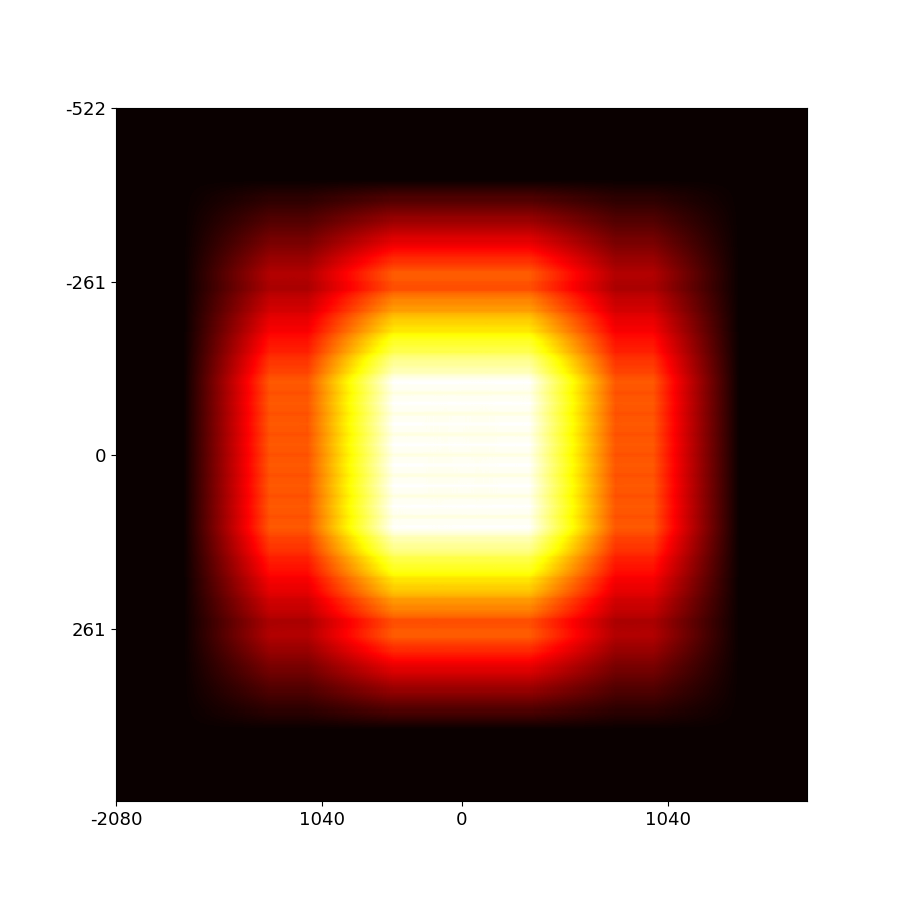

In [18]:
plt.figure(figsize=(9, 9))
#plt.title('$B$\n', fontsize=16)
#plt.xticks([0, 519, 1039], labels=[-130,0, 130], fontsize=13)
#plt.yticks([0, 260, 521], labels=[130.5,0, -130.5], fontsize=13)
#plt.xlabel("\nFine resolution direction (x) [mm]", fontsize=16)
#plt.ylabel("\nCoarse resolution direction (y) [mm]", fontsize=16)

plt.xticks([0, 620, 1040, 1660, 2080], labels=[-2080, 1040, 0, 1040, 2080], fontsize=13)
plt.yticks([0, 261, 522, 261+ 522, 1044], labels=[-522, -261, 0, 261, 522], fontsize=13)


#ax.set_yticks(range(len(camera_reqs)), ha="right", labels=camera_reqs, fontsize=13)
plt.imshow(variance.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
#plt.rcParams['savefig.facecolor']='white'
#plt.savefig("LEM-X_bulk_array.pdf", format="pdf", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

In [19]:
variance

array([[ 9.42280357e-12,  9.41559943e-12,  9.41128684e-12, ...,
         9.09352857e-12,  9.08328724e-12,  9.08105331e-12],
       [ 1.92187355e-12,  1.92275236e-12,  1.92621053e-12, ...,
         1.93959519e-12,  1.93621595e-12,  1.93242528e-12],
       [-2.72374187e-12, -2.71524037e-12, -2.70884539e-12, ...,
        -2.89941271e-12, -2.90077897e-12, -2.89724768e-12],
       ...,
       [-1.63567015e-12, -1.64218661e-12, -1.65124360e-12, ...,
        -1.90444836e-12, -1.88951427e-12, -1.87549794e-12],
       [ 3.10328290e-12,  3.12729048e-12,  3.14764819e-12, ...,
         3.19811210e-12,  3.19516254e-12,  3.18234805e-12],
       [ 3.48350827e-12,  3.46160294e-12,  3.46035731e-12, ...,
         3.45634838e-12,  3.45481282e-12,  3.45101684e-12]],
      shape=(2079, 1043))

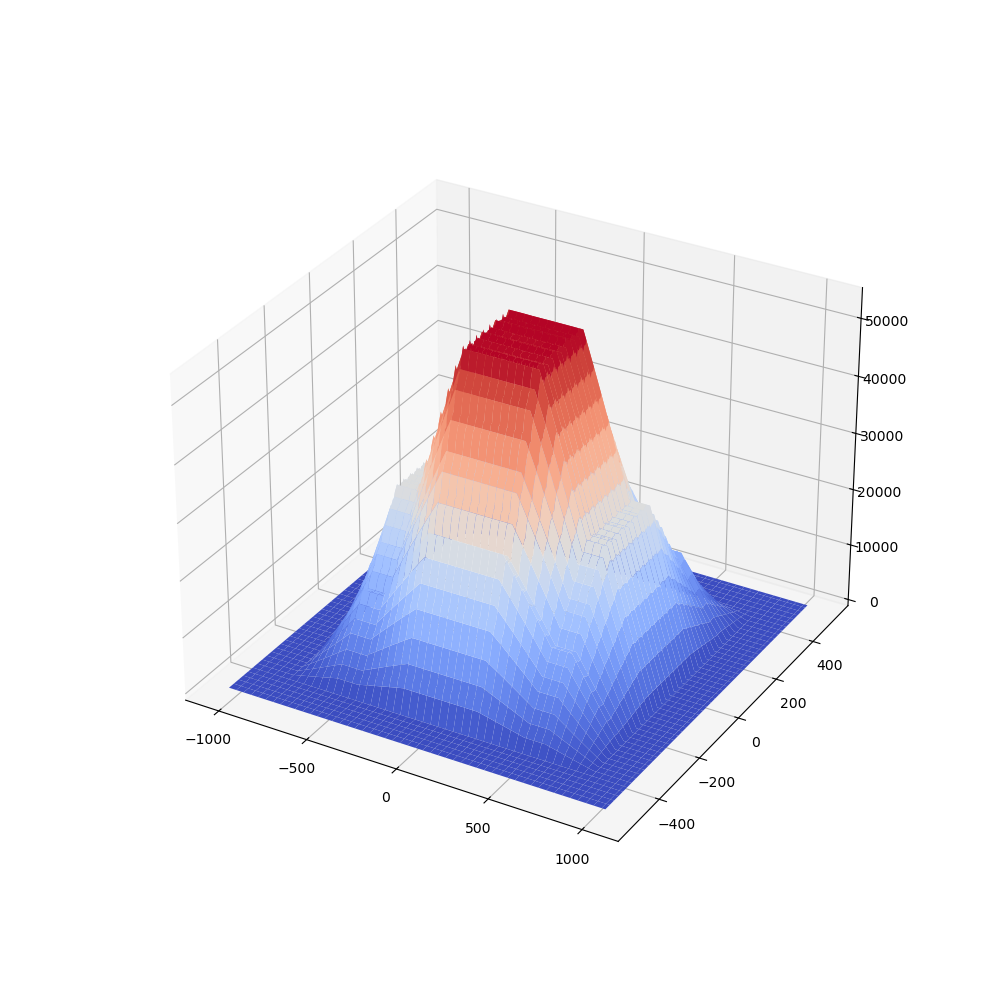

In [20]:
from matplotlib.ticker import LinearLocator
fig, ax = plt.subplots(  subplot_kw={"projection": "3d"}, figsize=(10, 10))

# Make data.
X = np.arange(0, 2079)-1040
Y = np.arange(0, 1043) - 522
X, Y = np.meshgrid(X, Y)
#R = np.sqrt(X**2 + Y**2)

# Plot the surface.
#surf = ax[0].plot_surface(X, Y, sky.T, cmap=cm.coolwarm, linewidth=0, antialiased=True)

surf = ax.plot_surface(X, Y, variance.T, cmap=cm.coolwarm, linewidth=0, antialiased=True)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


# COMPARING WITH WFM


In [21]:
wfm_mask_file = "F:/LEM-X/IROS/wfm_mask.fits"
mask_wfm, hdmask = read_mask_bulk(wfm_mask_file, 'MASK', header_out=True, verbose=False)
rmatrix_wfm = read_mask_bulk(wfm_mask_file, 'RMATRIX', verbose=False)
bulk_wfm = read_mask_bulk(wfm_mask_file, 'SENS', verbose=False)
bulk_wfm[bulk_wfm < 1] = 0

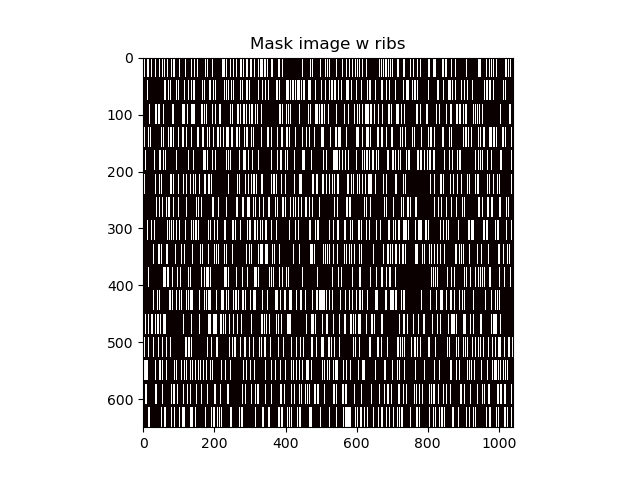

In [22]:
plt.figure()
plt.title('Mask image w ribs')
plt.imshow(mask_wfm.T, cmap=cm.hot,  interpolation='nearest', aspect=0.4/0.25)
plt.show()

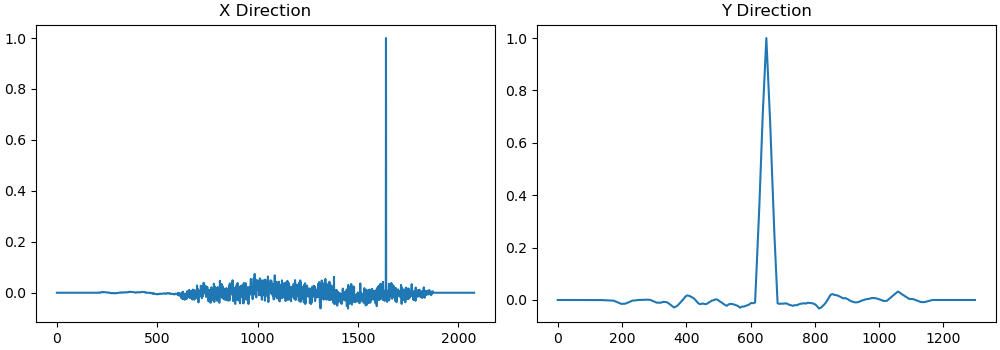

In [23]:
sky_wfm = decode(fshift(mask_wfm, -600, 0) * bulk_wfm, rmatrix_wfm, bulk_wfm)
peak_wfm = np.unravel_index(np.argmax(sky_wfm), sky_wfm.shape)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
axs[0].set_title('X Direction')
axs[0].plot(sky_wfm[:, peak_wfm[1]]/np.max(sky_wfm) )

axs[1].set_title('Y Direction')
axs[1].plot(sky_wfm[peak_wfm[0], :]/np.max(sky_wfm))
plt.show()

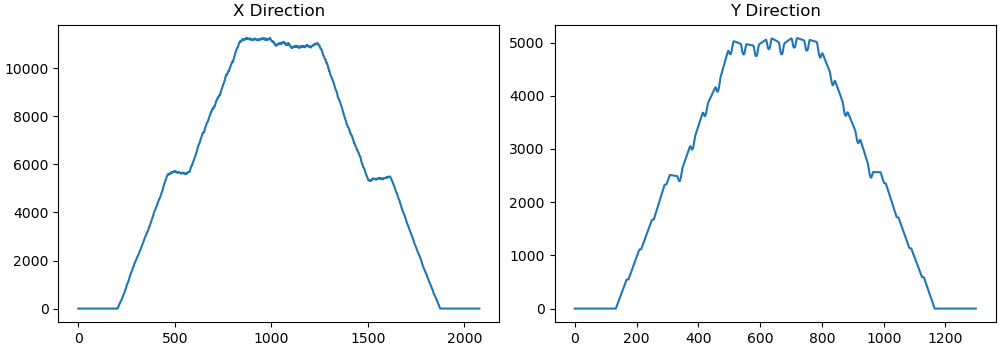

In [24]:
variance_wfm = decode_var(mask_wfm*bulk_wfm, rmatrix_wfm, bulk_wfm, focal, 0.25, 0.4)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
axs[0].set_title('X Direction')
axs[0].plot(variance_wfm[:, peak_wfm[1]])
axs[1].set_title('Y Direction')
axs[1].plot(variance_wfm[peak_wfm[0], :])
plt.show()

## Checking significance distribution for a flat bkg

In [25]:
dummy_det = np.random.poisson(lam=0.1, size=mask.shape) * bulk
dummy_det_wfm = np.random.poisson(lam=0.1, size=mask_wfm.shape) * bulk_wfm

dummy_sky = decode(dummy_det, rmatrix, bulk)
dummy_sky_wfm = decode(dummy_det_wfm, rmatrix_wfm, bulk_wfm)

variance = decode_var(dummy_det, rmatrix, bulk, focal, ELXDIM, ELYDIM)
variance_wfm = decode_var(dummy_det_wfm, rmatrix_wfm, bulk_wfm, focal, 0.25, 0.4)


variance_clipped = np.clip(variance, a_min=1E-8, a_max=np.sum(dummy_det)) if np.any(variance <= 0) else variance
variance_clipped_wfm = np.clip(variance_wfm, a_min=1E-8, a_max=np.sum(dummy_det_wfm)) if np.any(variance_wfm <= 0) else variance_wfm

dummy_sky = decode(dummy_det, rmatrix, bulk)
dummy_sky_wfm = decode(dummy_det_wfm, rmatrix_wfm, bulk_wfm)

dummy_sign = dummy_sky/np.sqrt(variance_clipped)
dummy_sign_wfm = dummy_sky_wfm/np.sqrt(variance_clipped_wfm)


dummy_sign = dummy_sign[205:-205, 134:-134 ]
dummy_sign_wfm = dummy_sign_wfm[205:-205, 134:-134 ]

dummy_sign_h, bins = np.histogram(dummy_sign.reshape(dummy_sign.size), bins=1000,  density=True)
dummy_sign_h_wfm, _ = np.histogram(dummy_sign_wfm.reshape(dummy_sign_wfm.size), bins=bins,  density=True)

In [26]:
from scipy.optimize import curve_fit
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))


binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

popt, _ = curve_fit(gauss, xdata=binscenters, ydata=dummy_sign_h, p0=[1, 0, 1.0])
popt_wfm, _ = curve_fit(gauss, xdata=binscenters, ydata=dummy_sign_h_wfm, p0=[1, 0, 1.0])

print("Sigma:", popt[2])
print("Sigma WFM:", popt_wfm[2])

Sigma: 0.9829887467305118
Sigma WFM: 0.9999073375821341


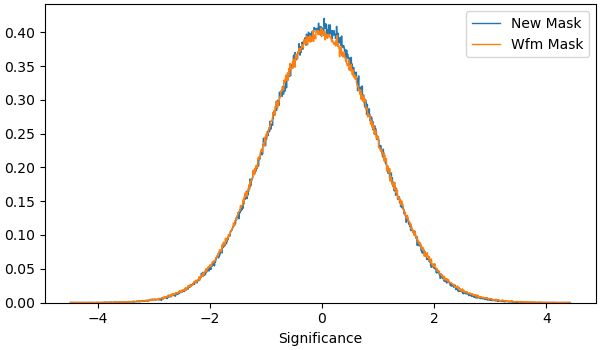

In [27]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 3.5))
plt.stairs(dummy_sign_h, bins, label="New Mask")
plt.stairs(dummy_sign_h_wfm, bins, label="Wfm Mask")
plt.xlabel("Significance")
plt.legend()
plt.show()

## VIGNETTING
Now we compare the off-axis response along the fine (X) and the coarse (Y) direction with the off-axis response of the WFM. Having a larger original open fraction (0.5 instead of 0.25) should mitigate the vignetting effect along the X direction, due to the larger probability of having adjacent open elements.

In [28]:
thetaX = np.linspace(-46, 46, 39)
thetaY = np.linspace(-46, 46, 39)

In [29]:
effarea_x = [0.01 * eff_area_vs_off_axis(mask.T.astype('int32'), bulk.T, ELXDIM, ELYDIM, focal, 0.150, theta, 0, degrees=True) for theta in thetaX]
effarea_wfm_x = [0.01 * eff_area_vs_off_axis(mask_wfm.T.astype('int32'), bulk_wfm.T, 0.25, 0.4, focal, 0.150, theta, 0, degrees=True) for theta in thetaX]

effarea_y = [0.01 * eff_area_vs_off_axis(mask.T.astype('int32'), bulk.T, ELXDIM, ELYDIM, focal, 0.150, 0, theta, degrees=True) for theta in thetaY]
effarea_wfm_y = [0.01 * eff_area_vs_off_axis(mask_wfm.T.astype('int32'), bulk_wfm.T, 0.25, 0.4, focal, 0.150, 0, theta, degrees=True) for theta in thetaY]

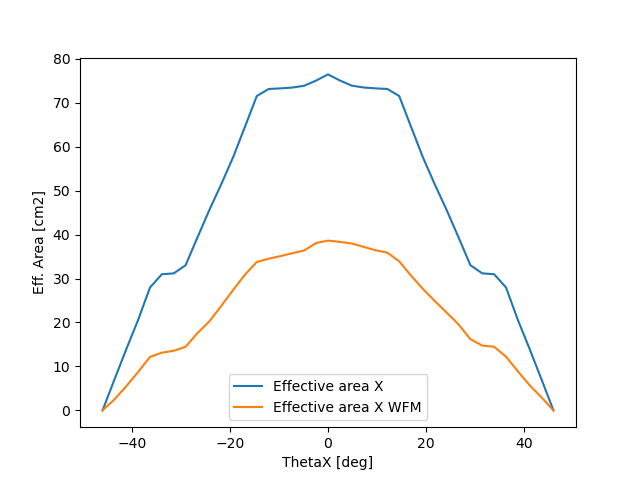

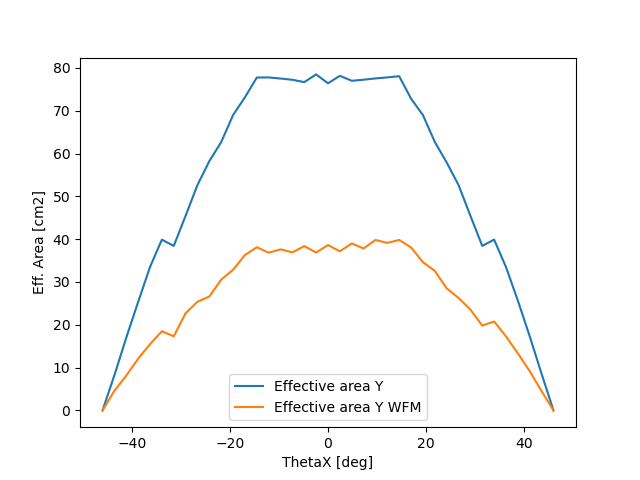

In [30]:
plt.figure()
plt.plot(thetaX, effarea_x, label="Effective area X")
plt.plot(thetaX, effarea_wfm_x, label="Effective area X WFM")
plt.xlabel("ThetaX [deg]")
plt.ylabel("Eff. Area [cm2]")

plt.legend()
plt.show()

plt.figure()
plt.plot(thetaY, effarea_y, label="Effective area Y")
plt.plot(thetaY, effarea_wfm_y, label="Effective area Y WFM")
plt.xlabel("ThetaX [deg]")
plt.ylabel("Eff. Area [cm2]")
plt.legend()
plt.show()

Text(0, 0.5, 'Eff. Area')

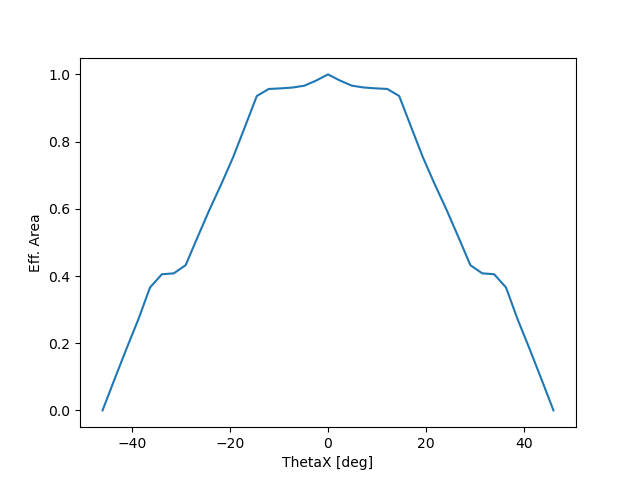

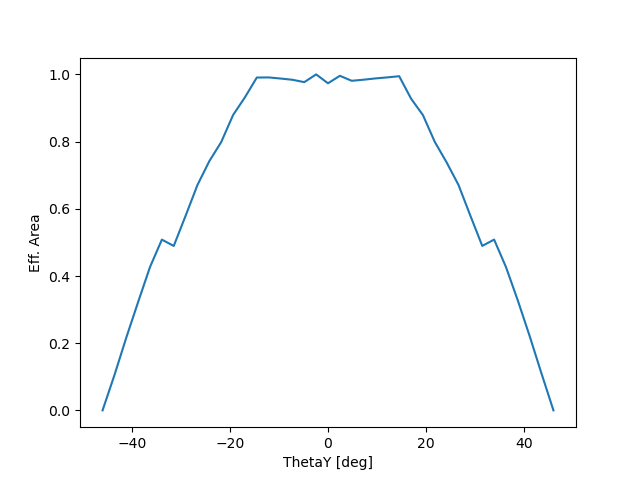

In [31]:
plt.figure()
plt.plot(thetaX, effarea_x/np.max(effarea_x), label="Effective area X")
plt.xlabel("ThetaX [deg]")
plt.ylabel("Eff. Area")


plt.figure()
plt.plot(thetaY, effarea_y/np.max(effarea_y), label="Effective area Y")
plt.xlabel("ThetaY [deg]")
plt.ylabel("Eff. Area")


## RESPONSE TO NON-FLAT BACKGROUND

In [32]:
omega = solid_angle(bulk, ELXDIM, ELYDIM, 202.9)
omega_norm = omega * 3.0  #mean background rate for 1ks observation - from FC sims
bkg_det = np.random.poisson(lam=omega_norm, size=bulk.shape) * bulk


omega_wfm = solid_angle(bulk_wfm, 0.25, 0.4, 202.9)
omega_norm_wfm = omega_wfm * 1.2  #mean background rate for 1ks observation - from FC sims
bkg_det_wfm = np.random.poisson(lam=omega_norm_wfm, size=bulk_wfm.shape) * bulk_wfm


In [33]:
print("New mask bkg counts (1ks):", np.sum(bkg_det))
print("WFM mask bkg counts (1ks):", np.sum(bkg_det_wfm))

New mask bkg counts (1ks): 474180.0
WFM mask bkg counts (1ks): 237323.0


In [34]:
bkg_sky = decode(bkg_det, rmatrix, bulk)
bkg_variance = decode_var(bkg_det, rmatrix, bulk, focal, ELXDIM, ELYDIM)
bkg_variance_clipped = np.clip(bkg_variance, a_min=1E-8, a_max=np.sum(bkg_det)) if np.any(bkg_variance <= 0) else bkg_variance
bkg_sign = bkg_sky/np.sqrt(bkg_variance_clipped)
bkg_sign = bkg_sign[205:-205, 134:-134 ]

bkg_sky_wfm = decode(bkg_det_wfm, rmatrix_wfm, bulk_wfm)
bkg_variance_wfm = decode_var(bkg_det_wfm, rmatrix_wfm, bulk_wfm, focal, 0.25, 0.4)
bkg_variance_clipped_wfm = np.clip(bkg_variance_wfm, a_min=1E-8, a_max=np.sum(bkg_det_wfm)) if np.any(bkg_variance_wfm <= 0) else bkg_variance_wfm
bkg_sign_wfm = bkg_sky_wfm/np.sqrt(bkg_variance_clipped_wfm)
bkg_sign_wfm = bkg_sign_wfm[205:-205, 134:-134 ]

bkg_sign_h, bins = np.histogram(bkg_sign.reshape(bkg_sign.size), bins=1000,  density=True)
bkg_sign_h_wfm, _ = np.histogram(bkg_sign_wfm.reshape(bkg_sign_wfm.size), bins=1000,  density=True)

binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

popt, _ = curve_fit(gauss, xdata=binscenters, ydata=bkg_sign_h, p0=[1, 0, 1.0])
popt_wfm, _ = curve_fit(gauss, xdata=binscenters, ydata=bkg_sign_h_wfm, p0=[1, 0, 1.0])

print("Sigma:", popt[2])
print("Sigma:", popt_wfm[2])

Sigma: 1.0697546831164602
Sigma: 1.1994140519809402


C:\Users\Utente\AppData\Local\Temp\ipykernel_9736\2145871069.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 3.5))


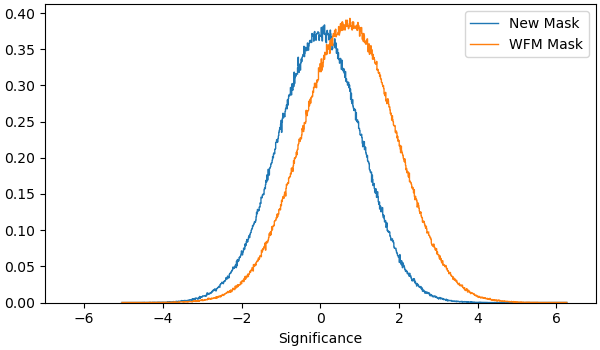

In [35]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 3.5))
plt.stairs(bkg_sign_h, bins, label="New Mask")
plt.stairs(bkg_sign_h_wfm, bins, label="WFM Mask")
plt.xlim(-7,7)
plt.xlabel("Significance")
plt.legend()
plt.show()

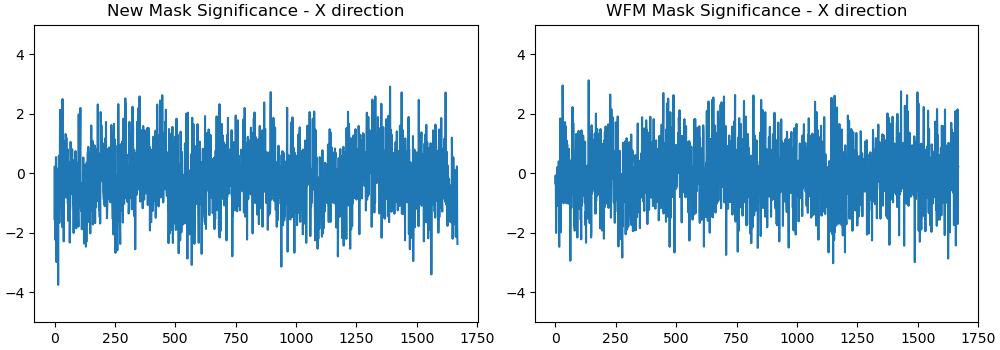

In [36]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
axs[0].set_title('New Mask Significance - X direction')
axs[0].plot(bkg_sign[:, int(bkg_sky.shape[1]//2)])
axs[0].set_ylim(-5, 5)
axs[1].set_title('WFM Mask Significance - X direction')
axs[1].plot(bkg_sign_wfm[:, int(bkg_sky_wfm.shape[1]//2)])
axs[1].set_ylim(-5, 5)

plt.show()

In [45]:
mask_props_0 = {
'AREA'    : 0.01 * mask.shape[0] * ELXDIM * mask.shape[1] * ELYDIM,
'HSMINX'  : 0.0, 
'HSMAXX'  : 64.896, 
'HSSIDEX' : 64.896, 
'HSMINY'  : 0.0, 
'HSMAXY'  : 35.088, 
'HSSIDEY' : 35.088, 
'HSMINZ'  : -0.225, 
'HSMAXZ'  : 0.225, 
'DETTHK'  : 0.45, 
'HSDDTHK' : 0.002014, 
'MAXDRIFT': 35.088, 
'MAXANODE': 64.896, 
'ANODEPIT': 0.169, 
'NANODES' : 384, 
'PLNXMIN' : -78.988, 
'PLNXMAX' : 78.988, 
'PLNXSIZE': 157.976, 
'PLNYMIN' : -76.5255, 
'PLNYMAX' : 76.5255, 
'PLNYSIZE': 153.051, 
'MDDIST'  : 202.9, 
'MASKTHK' : 0.150, 
'MSKDDTHK': 0.001295    
}

mask_props = {
    'MINX': np.round(-(mask.shape[0] * ELXDIM)/2, decimals=3),
    'MAXX': np.round( (mask.shape[0] * ELXDIM)/2, decimals=3),
    'MINY': np.round(-(mask.shape[1] * ELYDIM)/2, decimals=3),
    'MAXY': np.round( (mask.shape[1] * ELYDIM)/2, decimals=3),
    'ELXDIM': ELXDIM, 
    'ELYDIM': ELYDIM,
    'ELXN': mask.shape[0],
    'ELYN': mask.shape[1],
    'MXDIM':  mask.shape[0] * ELXDIM,
    'MYDIM':  mask.shape[1] * ELYDIM,
    'DXSLIT': mpitch_x, 
    'DYSLIT': mpitch_y, 
    'NXSLIT': xele, 
    'NYSLIT': yele, 
    'DXRIB': 0, 
    'DYRIB': ribsize_y, 
    'NXRIB': 0, 
    'NYRIB': yele-1, 
    'ALPHA': np.min(rmatrix), 
    'OPENFR': np.sum(mask)/mask.size,
    'RLOPENFR': original_of, 
    'MASKTHK': 0.150,
    'GENPRIME': prime_gen,
    'CODESHFT': opt_shift,
    'RESHAPE': 'C'
}

write_mask_fits("mask_050_1040x17_20250725_no_ribs.fits", mask_original[:, int(ribsize_y/ELYDIM)-1:-1], rmatrix, bulk, mask_props, mask_props_0)

{'MINX': np.float64(-130.0),
 'MAXX': np.float64(130.0),
 'MINY': np.float64(-130.5),
 'MAXY': np.float64(130.5),
 'ELXDIM': 0.25,
 'ELYDIM': 0.5,
 'ELXN': 1040,
 'ELYN': 522,
 'MXDIM': 260.0,
 'MYDIM': 261.0,
 'DXSLIT': 0.25,
 'DYSLIT': 15.5,
 'NXSLIT': 1040,
 'NYSLIT': 17,
 'DXRIB': 0,
 'DYRIB': 2.5,
 'NXRIB': 0,
 'NYRIB': 16,
 'ALPHA': np.float64(-0.9998868778280543),
 'OPENFR': np.float64(0.4386678455643973),
 'RLOPENFR': np.float64(0.5),
 'MASKTHK': 0.15,
 'GENPRIME': 17681,
 'CODESHFT': 17680,
 'RESHAPE': 'C'}

Total row count 542880


In [44]:
print(mask_original[:, int(ribsize_y/ELYDIM)-1:-1].shape)
print(mask.shape)

(1040, 522)
(1040, 522)
